<a href="https://colab.research.google.com/github/Osama2321/Food-classification/blob/main/food_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau


Found categories: ['beignets', 'bibimbap', 'bread_pudding', 'beet_salad']


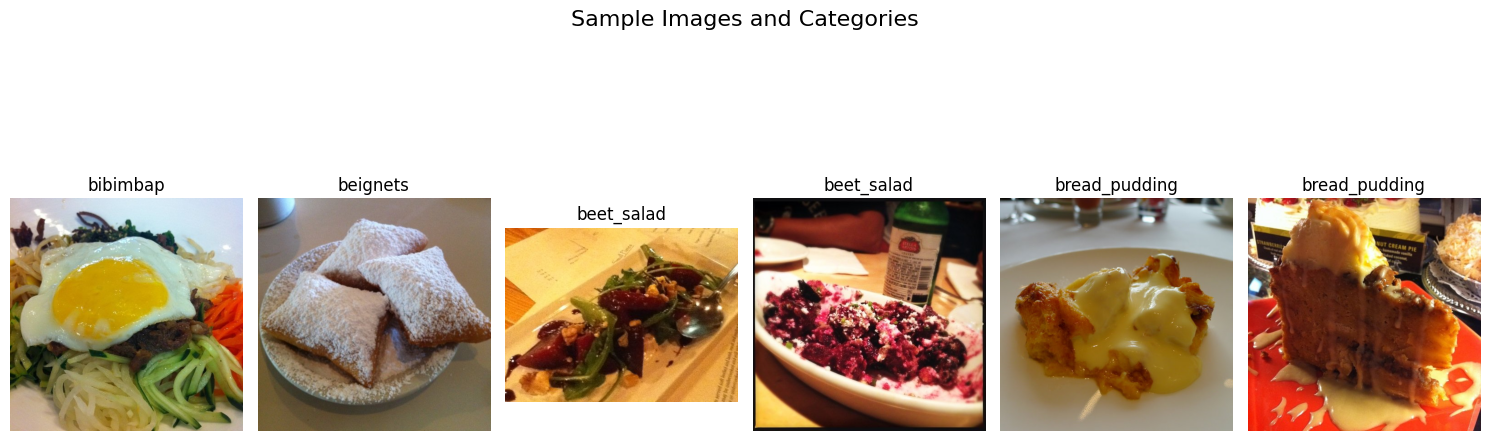

In [ ]:
train_dir = '/train'
validation_dir = '/val'
test_dir = '/test'

def display_sample_images(data_dir, num_samples=6):
    """
    Displays sample images and their categories from the dataset.

    Parameters:
    - data_dir: Directory containing the dataset.
    - num_samples: Number of images to display.
    """
    categories = os.listdir(data_dir)
    categories = [cat for cat in categories if os.path.isdir(os.path.join(data_dir, cat))]  # Filter only folders

    print(f"Found categories: {categories}")

    # Prepare the plot
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 6))
    fig.suptitle("Sample Images and Categories", fontsize=16)

    for i in range(num_samples):
        # Randomly select a category
        category = random.choice(categories)
        category_path = os.path.join(data_dir, category)

        # Randomly select an image from the category
        image_name = random.choice(os.listdir(category_path))
        image_path = os.path.join(category_path, image_name)

        # Load and display the image
        img = mpimg.imread(image_path)
        axes[i].imshow(img)
        axes[i].set_title(category)
        axes[i].axis('off')

    plt.tight_layout()

    plt.show()

# Example usage:
# Display sample images from the training set
display_sample_images(train_dir, num_samples=6)


In [ ]:
image_size = (150, 150)
batch_size = 32

# Train data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,        # Random rotation within 30 degrees
    width_shift_range=0.2,    # Random horizontal shift
    height_shift_range=0.2,   # Random vertical shift
    shear_range=0.2,          # Shear transformations
    zoom_range=0.2,           # Random zoom
    horizontal_flip=True,     # Randomly flip images horizontally
    fill_mode='nearest'       # Fill strategy for augmented pixels
)

# Validation and test data generators without augmentation
val_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Load datasets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)


Found 2800 images belonging to 4 classes.
Found 800 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


In [ ]:
# Pretrained VGG16 model
base_model = VGG16(input_shape=(150, 150, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

# Build the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Global pooling
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),  # Batch normalization
    layers.Dropout(0.5),  # Dropout
    layers.Dense(len(train_generator.class_indices), activation='softmax')  # Output layer
])

# Compile the model
learning_rate = 0.001
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Learning rate scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Train the model
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[reduce_lr]
)

# Fine-tune the model
base_model.trainable = True  # Unfreeze the base model
# Recompile with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_fine_tune = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[reduce_lr]
)


Epoch 1/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 44s 453ms/step - accuracy: 0.4713 - loss: 1.2814 - val_accuracy: 0.7175 - val_loss: 0.8867 - learning_rate: 0.0010
Epoch 2/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 74s 374ms/step - accuracy: 0.6856 - loss: 0.7947 - val_accuracy: 0.7513 - val_loss: 0.7412 - learning_rate: 0.0010
Epoch 3/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 40s 364ms/step - accuracy: 0.7142 - loss: 0.7302 - val_accuracy: 0.7387 - val_loss: 0.6527 - learning_rate: 0.0010
Epoch 4/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 35s 362ms/step - accuracy: 0.7185 - loss: 0.6871 - val_accuracy: 0.8000 - val_loss: 0.5409 - learning_rate: 0.0010
Epoch 5/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 33s 356ms/step - accuracy: 0.7566 - loss: 0.6448 - val_accuracy: 0.8075 - val_loss: 0.5250 - learning_rate: 0.0010
Epoch 6/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 43s 374ms/step - accuracy: 0.7506 - loss: 0.6358 - val_accuracy: 0.7825 - val_loss: 0.5526 - learning_rate: 0.0010
Epoch 7/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 35s 370ms/step - accuracy: 0.7941 - loss: 0.

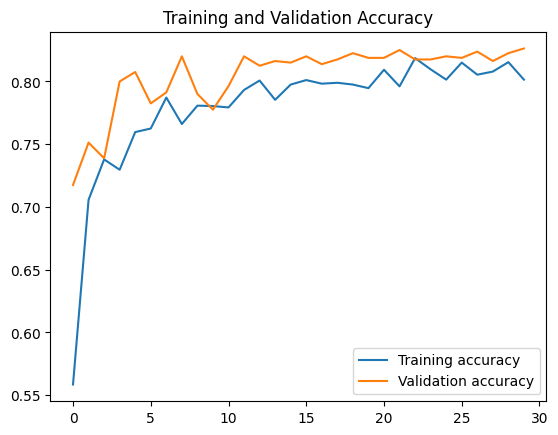

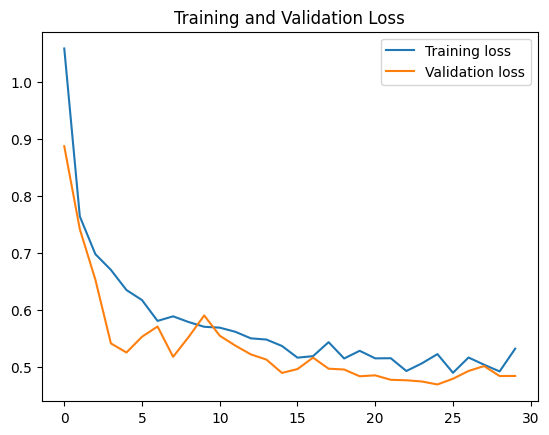

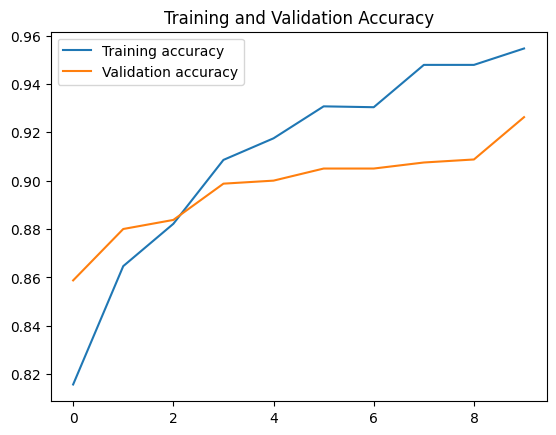

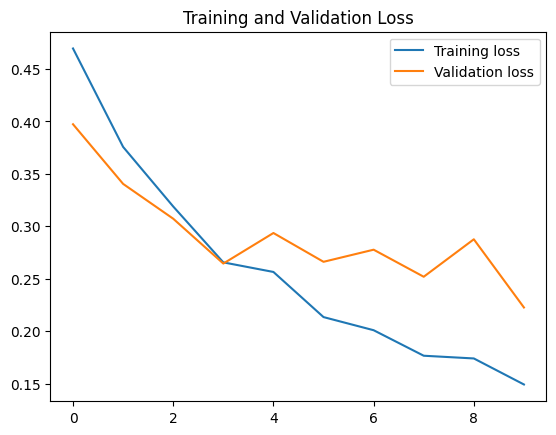

In [ ]:
def plot_metrics(history, metric='accuracy'):
    plt.plot(history.history[metric], label=f'Training {metric}')
    plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
    plt.title(f'Training and Validation {metric.capitalize()}')
    plt.legend()
    plt.show()

plot_metrics(history, 'accuracy')
plot_metrics(history, 'loss')
plot_metrics(history_fine_tune, 'accuracy')
plot_metrics(history_fine_tune, 'loss')

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


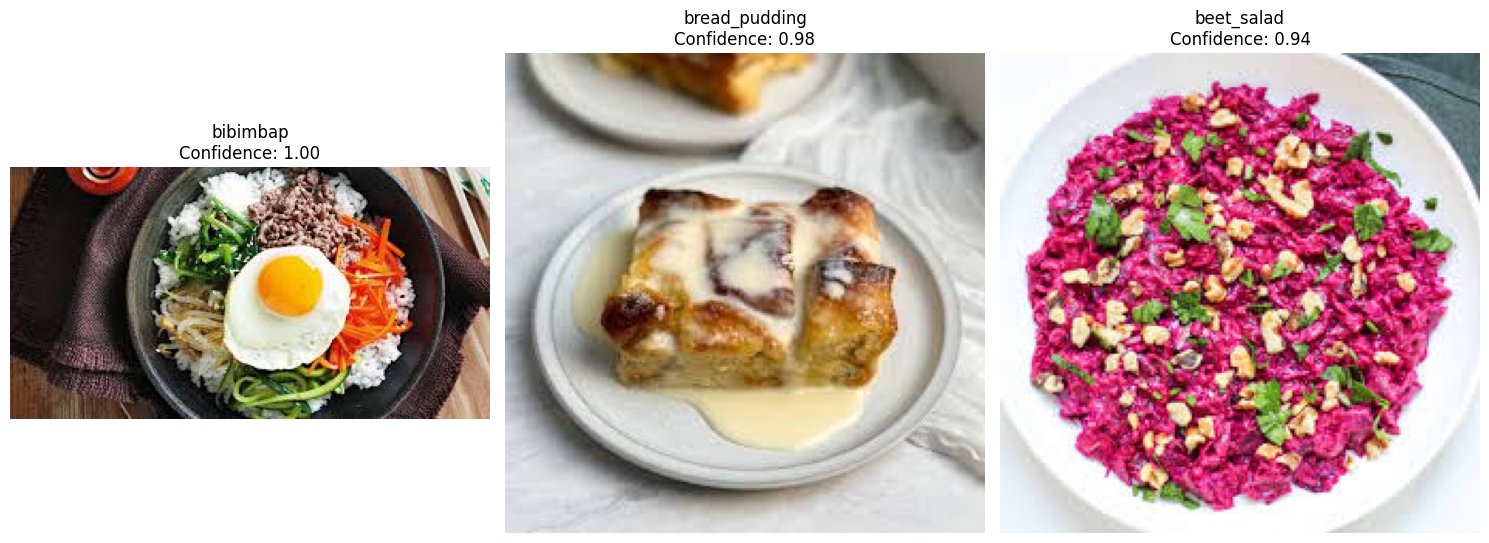

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def predict_image(model, image_path, class_indices, image_size=(150, 150)):
    """
    Predict the class of an image using a trained model.

    Parameters:
    - model: The trained model.
    - image_path: Path to the image to predict.
    - class_indices: A dictionary mapping class names to indices.
    - image_size: Target size to resize the image.

    Returns:
    - Predicted class and confidence score.
    """
    # Load and preprocess the image
    img = load_img(image_path, target_size=image_size)
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Rescale pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict the class
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions[0])
    confidence_score = predictions[0][predicted_class_index]

    # Map index to class name
    class_names = {v: k for k, v in class_indices.items()}  # Reverse the mapping
    predicted_class = class_names[predicted_class_index]

    return predicted_class, confidence_score

def display_and_predict(model, image_paths, class_indices, image_size=(150, 150)):
    """
    Display images and predict their classes.

    Parameters:
    - model: The trained model.
    - image_paths: List of image file paths.
    - class_indices: Class indices dictionary.
    - image_size: Target size for resizing images.
    """
    fig, axes = plt.subplots(1, len(image_paths), figsize=(15, 6))
    if len(image_paths) == 1:
        axes = [axes]  # Ensure axes is iterable for a single image

    for ax, image_path in zip(axes, image_paths):
        # Predict the class
        predicted_class, confidence_score = predict_image(model, image_path, class_indices, image_size)

        # Display the image and prediction
        img = mpimg.imread(image_path)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"{predicted_class}\nConfidence: {confidence_score:.2f}")

    plt.tight_layout()
    plt.show()

# Example usage:
# Provide the paths to your prompt images
prompt_images = [
    "/content/mii.jfif",
    "/content/bread.jfif",
    "/content/salad.jfif"
]

# Display and predict
display_and_predict(model, prompt_images, train_generator.class_indices, image_size=(150, 150))


In [ ]:
# Save the trained model
model.save("vgg16_fine_tuned_model.h5")


In [ ]:
import gradio as gr
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
model = load_model("vgg16_fine_tuned_model.h5")

# Define class labels (get from the class_indices)
class_labels = list(train_generator.class_indices.keys())

def predict_image(img):
    """
    Preprocess and predict the category of the image.
    """
    # Resize image to match model input size
    img = img.resize((150, 150))
    img_array = img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Expand dims to batch

    # Make predictions
    predictions = model.predict(img_array)
    predicted_class = class_labels[np.argmax(predictions)]
    confidence = np.max(predictions)

    return f"Predicted: {predicted_class}, Confidence: {confidence:.2f}"

# Gradio Interface
interface = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="Image Classification with VGG16",
    description="Upload an image to classify it using the fine-tuned VGG16 model."
)

# Launch the Gradio app
interface.launch(share=True)  # `share=True` generates a public URL for the app

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://29c592251c51247cee.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
